In [76]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# 0. Introdução

Os métodos de aprendizado de máquina que vamos empregar utilizam um subconjunto dos dados disponíveis para _treinar_ um algoritmo e outros subconjunto para _testar_ o resultado do treino e verificar a pe rformance do método em dados que não foram utilizados para o treinamento.

Esta linguagem é genérica e se aplica a todos os algoritmos, o que é prático para discutir os passos de uma dada análise. Por outro lado, ela obscurece o que está ocorrendo de fato no período de treinamento. Cada método possui seu próprio algoritmo, e estes possuem—na maior parte dos casos!—bases matemáticas robustas, calcadas na estatística e na teoria de otimização.

Neste notebook, vamos criar conjuntos de treino e teste, aplicar cada um dos algoritmos acima aos nossos dados e avaliar sua performance.

# 1. Preparação de amostras de treino e teste

In [77]:
# Load the first CSV file (assumes it contains the test data)
data = pd.read_csv("./des_match_vvds_clean.csv")

# The 'z' columns is the target and the 'mag_*' and 'mag_err_' columns are the predictor
y = data['z']
X = data[['mag_auto_g_dered',
          'mag_auto_r_dered',
          'mag_auto_i_dered',
          'mag_auto_z_dered',
          'mag_auto_y_dered',
          'magerr_auto_g',
          'magerr_auto_r',
          'magerr_auto_i',
          'magerr_auto_z',
          'magerr_auto_y']]

**Ex. 1: Split the data into training and test sets (e.g., 70/30 split)**

In [79]:
# Enter your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# 2. Treino/teste de três algoritmos de aprendizado de máquina e avaliação de sua performance

# 2.1 Treinando e testando os algoritmos

Nesta subseção, vamos treinar e testar uma _árvore de decisão_, uma _rede neural simples_ ("multi-layer perceptron") e uma _floresta aleatória_ nos dados que preparamos.  As três rodadas utilizarão a interface do scikit-learn para padronizar o código.

### 2.1.1. Rede neural (Multi-layer perceptron)

In [81]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

mlp_test_mae = mean_absolute_error(y_test, y_pred_mlp)
print("Multi-Layer Perceptron Validation MAE:", mlp_test_mae)

Multi-Layer Perceptron Validation MAE: 0.15217399757500213


### 2.1.2. Árvore de decisão (Decision tree)

In [82]:
# Insert your code here
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_test_mae = mean_absolute_error(y_test, y_pred_dt)
print("Decision Tree Validation MAE:", dt_test_mae)

Decision Tree Validation MAE: 0.1393717011128776


### 2.1.3. Floresta aleatória (Random forest)

In [83]:
# Insert your code here
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_test_mae = mean_absolute_error(y_test, y_pred_rf)
print("Random Forest Validation MAE:", rf_test_mae)

Random Forest Validation MAE: 0.10090583624801272


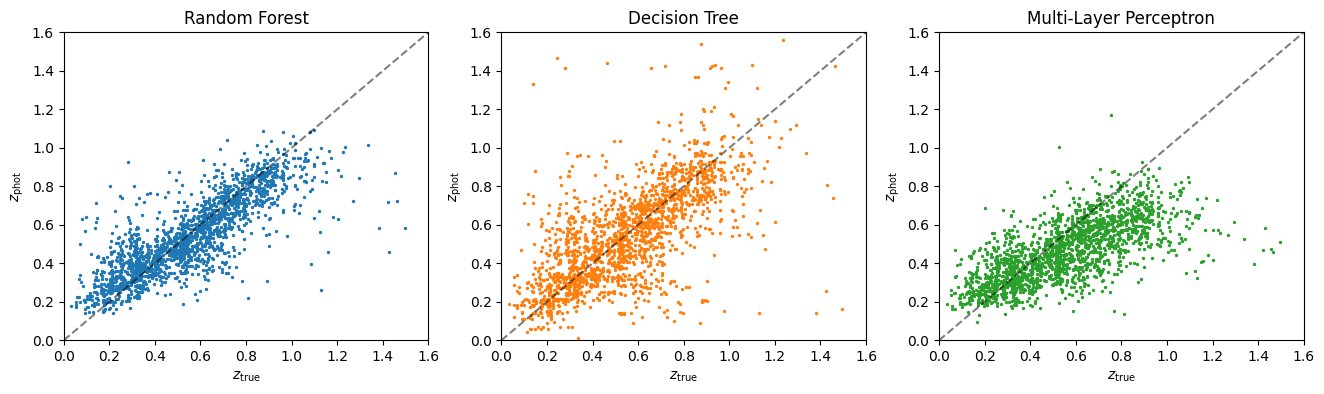

In [84]:
# Compare plots from three results

titles = ["Multi-Layer perceptron", "Decision tree", "Random forest"]
data_sets = [y_pred_mlp, y_pred_dt, y_pred_rf]
colors = ["C0", "C1", "C2"]

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.title("Random Forest")
plt.scatter(y_test, y_pred_rf, s=2, color="C0")
x = np.linspace(0, 1.6, 100)
plt.plot(x, x, "k--", alpha=0.5)
plt.ylim(0, 1.6)
plt.xlim(0, 1.6)
plt.xlabel(r"$z_\mathrm{true}$")
plt.ylabel(r"$z_\mathrm{phot}$")

plt.subplot(1, 3, 2)
plt.title("Decision Tree")
plt.scatter(y_test, y_pred_dt, s=2, color="C1")
x = np.linspace(0, 1.6, 100)
plt.plot(x, x, "k--", alpha=0.5)
plt.ylim(0, 1.6)
plt.xlim(0, 1.6)
plt.xlabel(r"$z_\mathrm{true}$")
plt.ylabel(r"$z_\mathrm{phot}$")

plt.subplot(1, 3, 3)
plt.title("Multi-Layer Perceptron")
plt.scatter(y_test, y_pred_mlp, s=2, color="C2")
x = np.linspace(0, 1.6, 100)
plt.plot(x, x, "k--", alpha=0.5)
plt.ylim(0, 1.6)
plt.xlim(0, 1.6)
_ = plt.xlabel(r"$z_\mathrm{true}$")
_ = plt.ylabel(r"$z_\mathrm{phot}$")

# 3. Quality assessment

In [85]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 path_to_save='',
                 title=None,
                 initial=0):

    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift.

    Args:

    zspec: Numpy array with the spectroscopic redshift.

    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.

    maximum: Float that indicates the redshift max of the plots.

    Kwargs:

    initial: Float that indicates the redshift min of the plots.



    '''
    bins = np.arange(0, 1.6, 0.1)
    points = bins + 0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz = []
    meanz = []
    outliers_2 = []
    drop_bins = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]

        binmask = (zphot >= bin_lower) & (zphot <= bin_upper)

        if not np.any(binmask):
            drop_bins.append(index)
            continue

        values_r = zphot[binmask]
        values_s = zspec[binmask]

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)

        # FIXME: This part of the code is really bad. That's not how you calculate a quantile!
        s = np.sort(np.abs(deltabias/(1 + values_s))) # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)

        # FIXME: This part of the code is really bad. That's not how you calculate a standard deviation!
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)

        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias - mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)

        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)

    points = np.delete(points, drop_bins)


    fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
    plt.subplots_adjust(hspace=0.1)

    axes[1]
    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    #axes[0].set_ylim(-0.05, 0.05)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    #axes[1].set_ylim(0, 0.03)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    #axes[1].set_ylim(0, 0.03)
    axes[1].set_yticks(np.arange(0, 0.25, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    #axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    #axes[3].set_ylim(0,0.12)
    axes[3].axhline(0.1, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)


    plt.suptitle(title)
    plt.xlim(0, 1.6)
    plt.tight_layout()

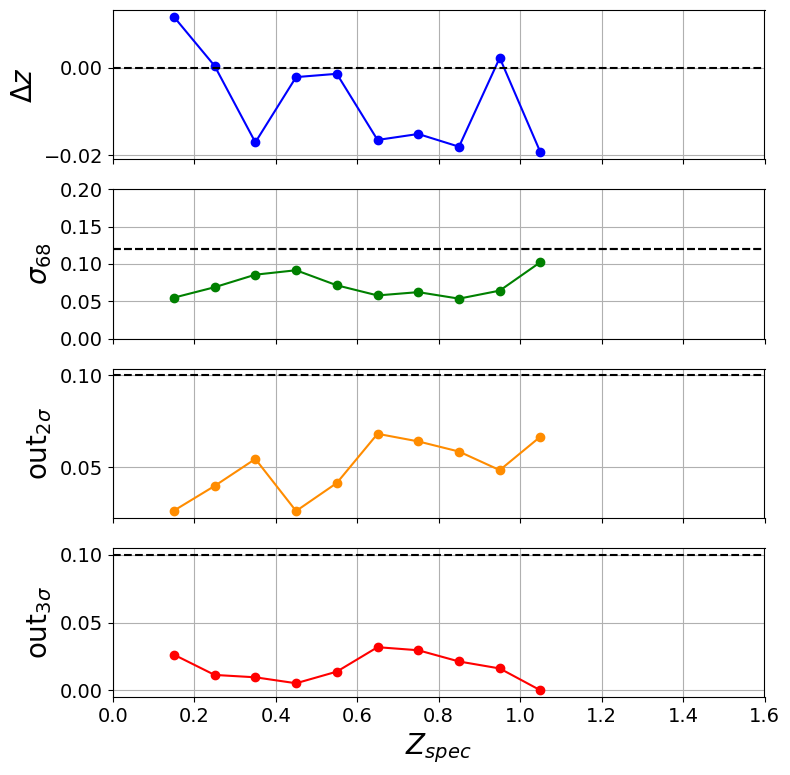

In [86]:
plot_metrics(y_test, y_pred_rf, 1.6, initial=0)

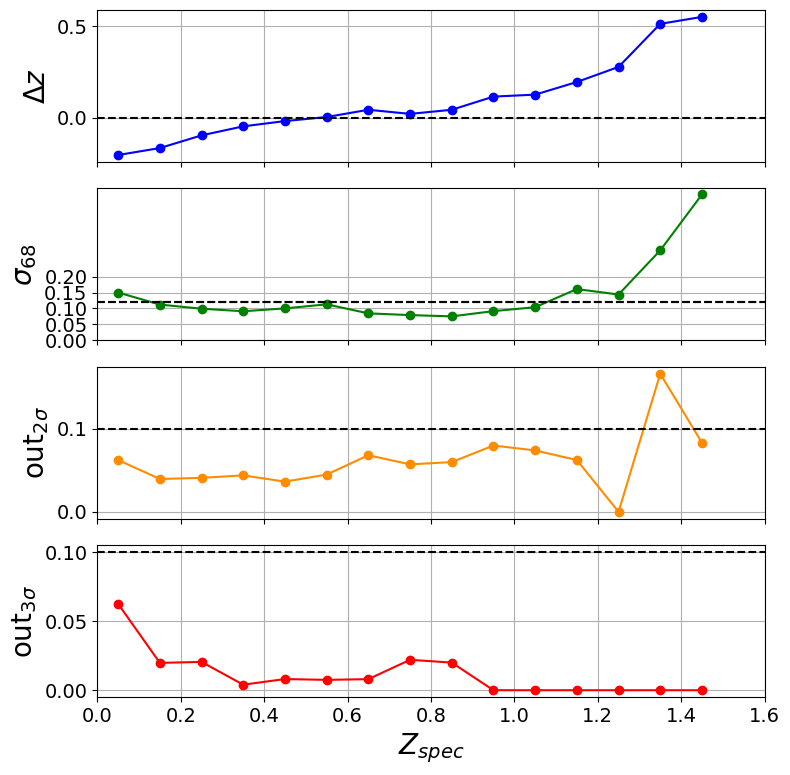

In [87]:
plot_metrics(y_test, y_pred_dt, 1.6, initial=0)

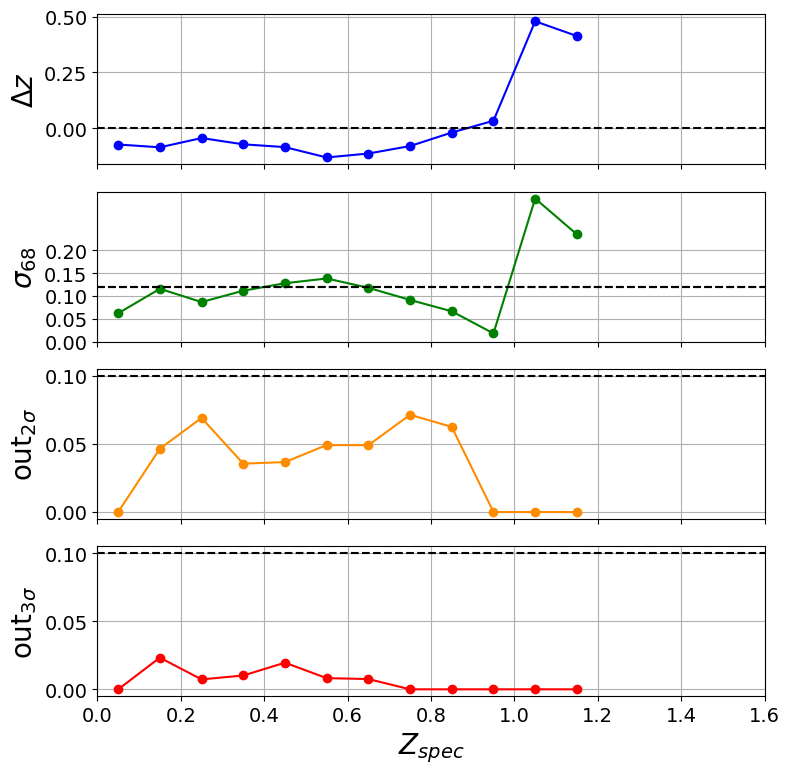

In [88]:
plot_metrics(y_test, y_pred_mlp, 1.6, initial=0)

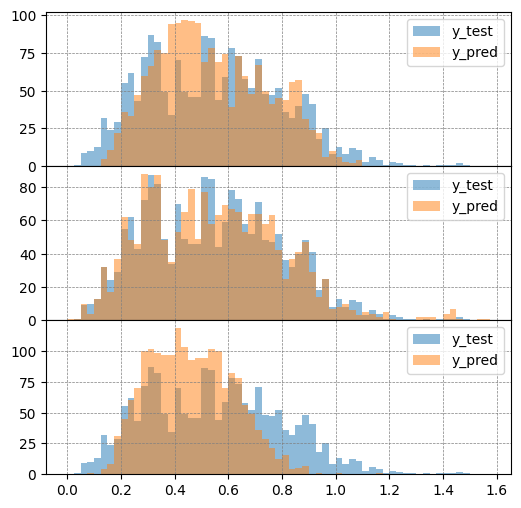

In [89]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=False)
plt.subplots_adjust(hspace=0.)

ax = axes[0]
#ax.set_xlabel('z', fontsize = 17)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
_ = ax.hist(y_test, bins=np.arange(0, 1.6, 0.025), density=False, color='C0', alpha=0.5)
_ = ax.hist(y_pred_rf, bins=np.arange(0, 1.6, 0.025), density=False, color='C1', alpha=0.5)
#ax.set_ylim(0, 160)
ax.legend(['y_test', 'y_pred'])

ax = axes[1]

#ax.set_xlabel('z', fontsize = 17)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
_ = ax.hist(y_test, bins=np.arange(0, 1.6, 0.025), density=False, color='C0', alpha=0.5)
_ = ax.hist(y_pred_dt, bins=np.arange(0, 1.6, 0.025), density=False, color='C1', alpha=0.5)
#ax.set_ylim(0, 160)
ax.legend(['y_test', 'y_pred'])

ax = axes[2]

#ax.set_xlabel('z', fontsize = 17)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
_ = ax.hist(y_test, bins=np.arange(0, 1.6, 0.025), density=False, color='C0', alpha=0.5)
_ = ax.hist(y_pred_mlp, bins=np.arange(0, 1.6, 0.025), density=False, color='C1', alpha=0.5)
#ax.set_ylim(0, 160)
ax.legend(['y_test', 'y_pred'])

# 4. Decision Tree Regression - With colors

In [90]:
# Load the first CSV file (assumes it contains the test data)
data = pd.read_csv("./des_match_vvds_clean.csv")

# The 'z' columns is the target and the 'mag_*' and 'mag_err_' columns are the predictor
N = len(data)
X_colors = np.zeros((N, 4))

X_colors[:, 0] = data['mag_auto_g_dered'] - data['mag_auto_r_dered']
X_colors[:, 1] = data['mag_auto_r_dered'] - data['mag_auto_i_dered']
X_colors[:, 2] = data['mag_auto_i_dered'] - data['mag_auto_z_dered']
X_colors[:, 3] = data['mag_auto_r_dered'] - data['mag_auto_z_dered']
z = data['z']


**Ex: Split the data into training and test sets (e.g., 70/30 split)**

In [91]:
# Insert code here
XC_train, XC_test, z_train, ztest = train_test_split(X_colors, z, test_size=0.30, random_state=42)

**Ex: Repeat the decision tree analysis**

In [92]:
# Insert code here
dt2 = DecisionTreeRegressor(random_state=42)
dt2.fit(XC_train, z_train)
zpred_color = dt2.predict(XC_test)

dt2_test_mae = mean_absolute_error(ztest, zpred_color)
print("Decision Tree Validation MAE:", dt2_test_mae)

Decision Tree Validation MAE: 0.12487037625861155


Text(0, 0.5, '$z_\\mathrm{phot}$')

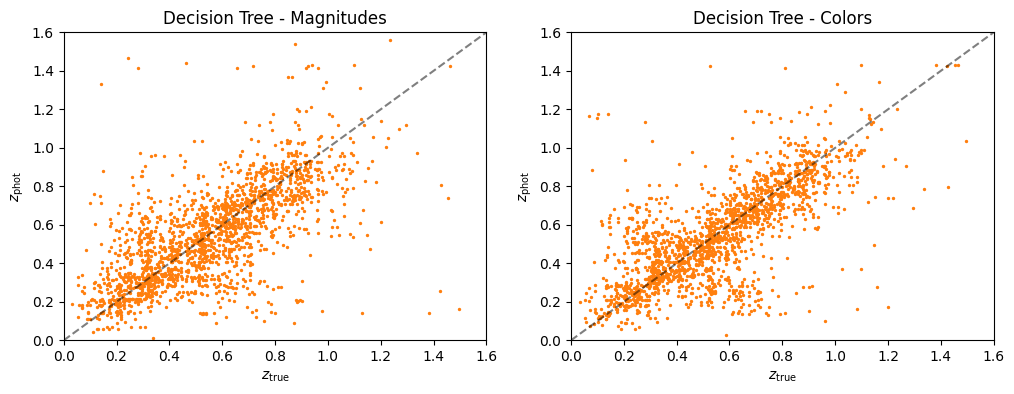

In [93]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Decision Tree - Magnitudes")
plt.scatter(y_test, y_pred_dt, s=2, color="C1")
x = np.linspace(0, 1.6, 100)
plt.plot(x, x, "k--", alpha=0.5)
plt.ylim(0, 1.6)
plt.xlim(0, 1.6)
plt.xlabel(r"$z_\mathrm{true}$")
plt.ylabel(r"$z_\mathrm{phot}$")

plt.subplot(1, 2, 2)
plt.title("Decision Tree - Colors")
plt.scatter(ztest, zpred_color, s=2, color="C1")
x = np.linspace(0, 1.6, 100)
plt.plot(x, x, "k--", alpha=0.5)
plt.ylim(0, 1.6)
plt.xlim(0, 1.6)
plt.xlabel(r"$z_\mathrm{true}$")
plt.ylabel(r"$z_\mathrm{phot}$")